In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install pmdarima
!pip install --upgrade seaborn statsmodels scikit-learn tensorflow keras

In [19]:
import os

import math

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential

from keras.layers import LSTM, Dense, Dropout

from keras.optimizers import Adam

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Input, Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error

# NVIDIA Stock Price Dataset (1999 - 2025) - Exploratory Data Analysis (EDA)

**📝 Dataset Overview**

* This dataset offers an extensive collection of historical stock data for NVIDIA Corporation, a global leader in graphics processing units (GPUs), artificial intelligence (AI), gaming, and data center technologies. NVIDIA has been at the forefront of technological innovation, and its stock performance is closely watched by investors, analysts, and tech enthusiasts.

* The dataset spans from the earliest available records from 1999 to 2025, providing a detailed look at the company's stock performance over time.

**📂 Data Source**

* Extracted using the yfinance Python library

* Covers stock data from 1999 to 2025 for long-term market analysis

**📊 Data Summary**

|Column Name    |Description                                          |
|---------------|-----------------------------------------------------|
|📅 Date       |Trading date (YYYY-MM-DD)                            |
|🔄 Adj Close  |Adjusted closing price after stock splits & dividends|
|📉 Close      |Closing stock price of the day                       |
|🔼 High       |Highest stock price of the day                       |
|🔽 Low        |Lowest stock price of the day                        |
|⬆️ Open       |Opening stock price of the day                       |
|📦Volume      |Number of shares traded                              |

In [4]:
NVIDIA_Stocks = pd.read_csv('NVDA.csv')
NVIDIA_Stocks

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000
...,...,...,...,...,...,...,...
6553,2025-02-10,133.570007,133.570007,135.000000,129.960007,130.089996,216989100
6554,2025-02-11,132.800003,132.800003,134.479996,131.020004,132.580002,178902400
6555,2025-02-12,131.139999,131.139999,132.240005,129.080002,130.020004,160278600
6556,2025-02-13,135.289993,135.289993,136.500000,131.169998,131.559998,197430000


In [5]:
NVIDIA_Stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6558 entries, 0 to 6557
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6558 non-null   object 
 1   Adj Close  6558 non-null   float64
 2   Close      6558 non-null   float64
 3   High       6558 non-null   float64
 4   Low        6558 non-null   float64
 5   Open       6558 non-null   float64
 6   Volume     6558 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 358.8+ KB


In [6]:
# Check for missing data
missing_data = NVIDIA_Stocks.isnull().sum()
print("Missing Data:\n", missing_data)

Missing Data:
 Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [7]:
# Ensure the 'Date' column is in datetime format
NVIDIA_Stocks['Date'] = pd.to_datetime(NVIDIA_Stocks['Date'])

# Set Date as index for better time-series handling
NVIDIA_Stocks.set_index('Date', inplace=True)

In [8]:
NVIDIA_Stocks.describe()

,Adj Close,Close,High,Low,Open,Volume
count,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03
mean,8.768532,8.795447,8.956567,8.618315,8.795850,5.991103e+08
std,23.907205,23.904882,24.349618,23.419200,23.922708,4.307236e+08
min,0.031286,0.034115,0.035547,0.033333,0.034896,1.968000e+07
25%,0.257739,0.281042,0.288511,0.273354,0.280810,3.384780e+08
50%,0.437176,0.466083,0.472875,0.459250,0.466584,5.002635e+08
75%,4.597059,4.644625,4.724000,4.588750,4.632437,7.307002e+08
max,149.429993,149.429993,153.130005,147.820007,153.029999,9.230856e+09


## Time Series Plot for NVIDIA Stock Price

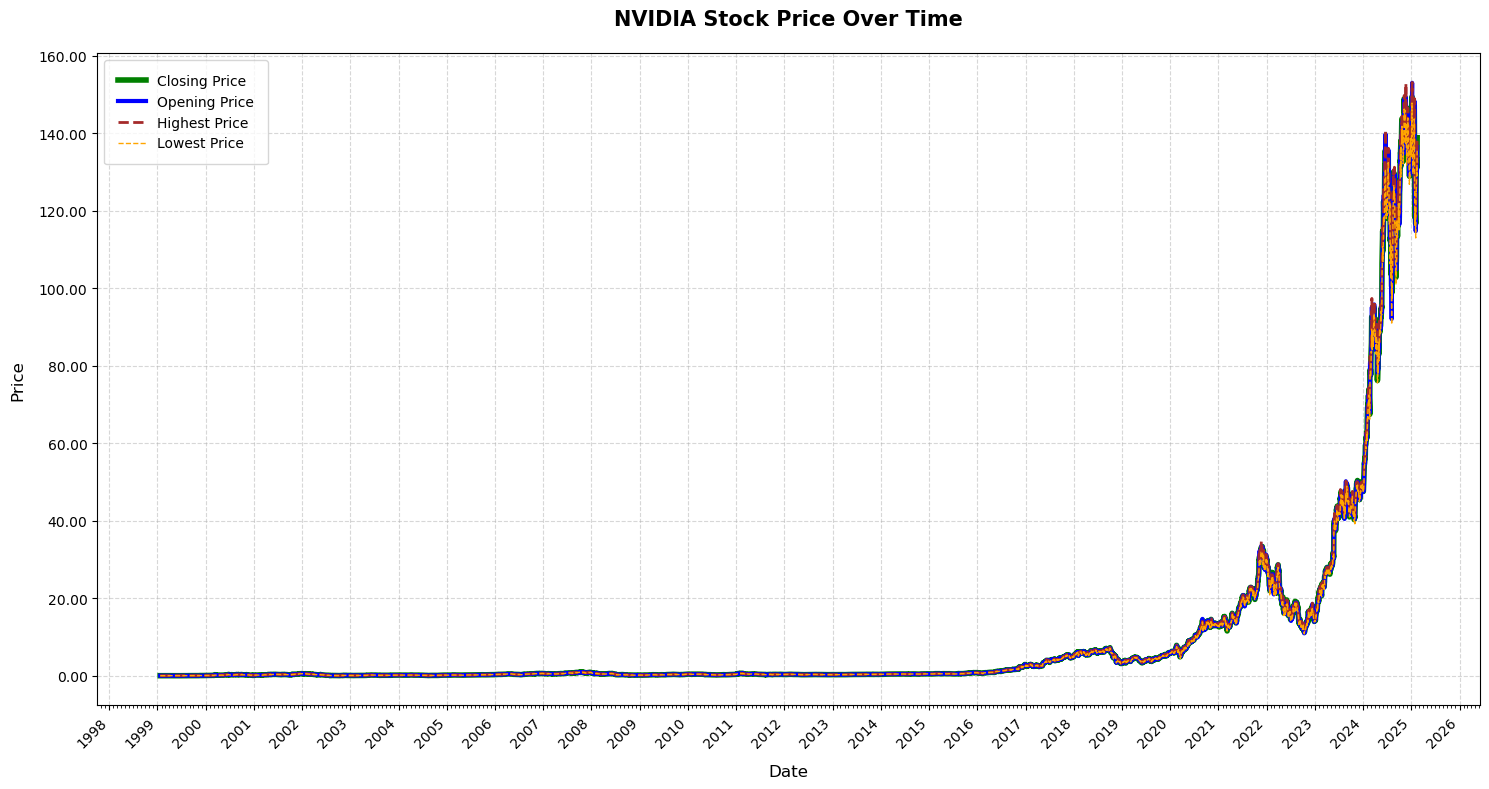

In [9]:
# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['Close'], label='Closing Price', color='green', linewidth=4)
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['Open'], label='Opening Price', color='blue', linewidth=3)
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['High'], label='Highest Price', color='brown', linewidth=2, linestyle='--')
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['Low'], label='Lowest Price', color='orange', linewidth=1, linestyle='--')

# Add title and labels
plt.title('NVIDIA Stock Price Over Time', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Price', fontsize=12, labelpad=10)

# Optimize xticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=10, rotation=45, ha='right')

# Optimize yticks
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## NVIDIA Stock Trading Volume Plot

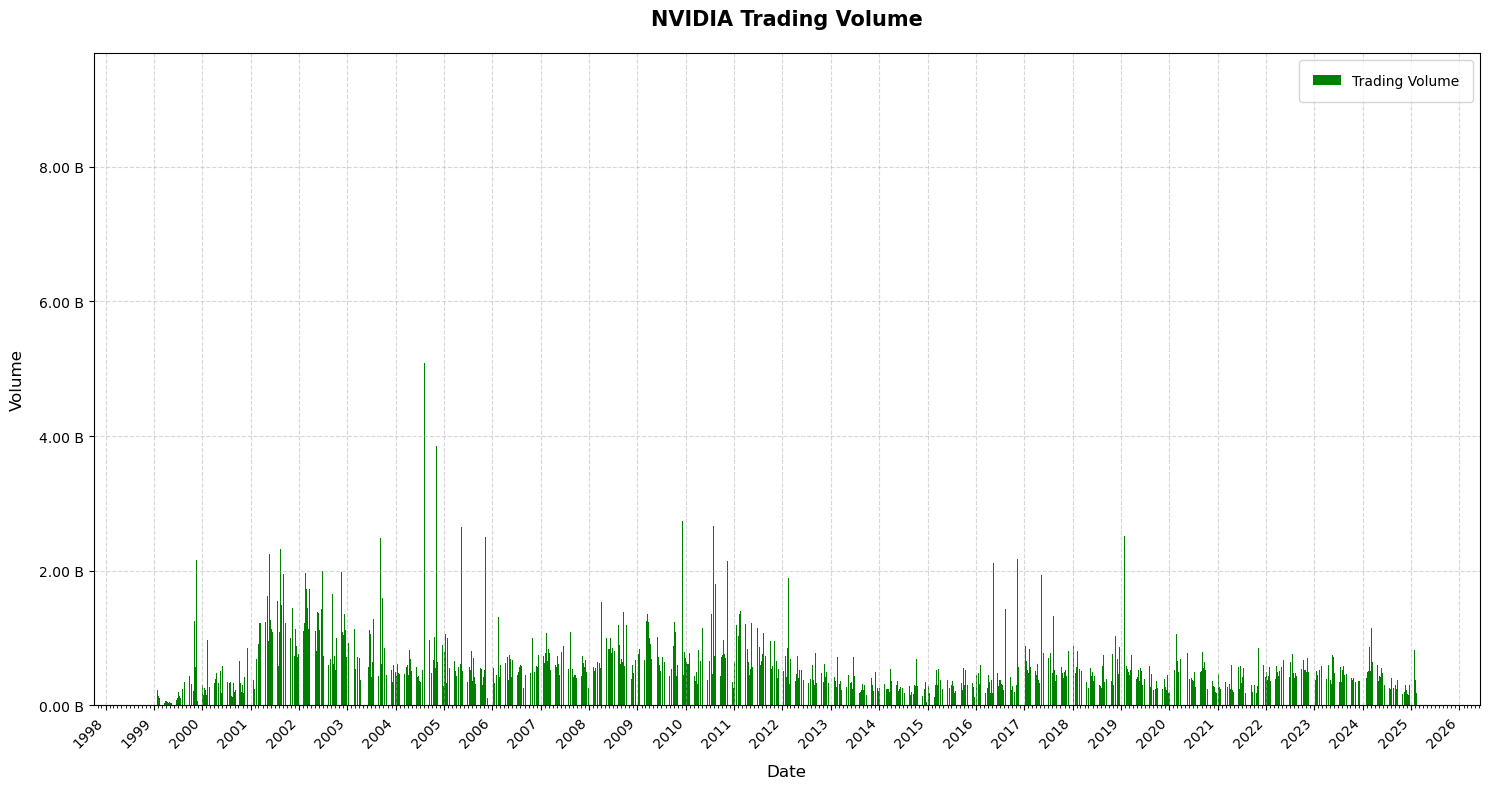

In [10]:
# Create the plot
plt.figure(figsize=(15, 8))
plt.bar(NVIDIA_Stocks.index, NVIDIA_Stocks['Volume'], color='green', label='Trading Volume')

# Add title and labels
plt.title('NVIDIA Trading Volume', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Volume', fontsize=12, labelpad=10)

# Optimize xticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=10, rotation=45, ha='right')

# Optimize yticks
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e9:.2f} B'))
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper right', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Distribution of Feature

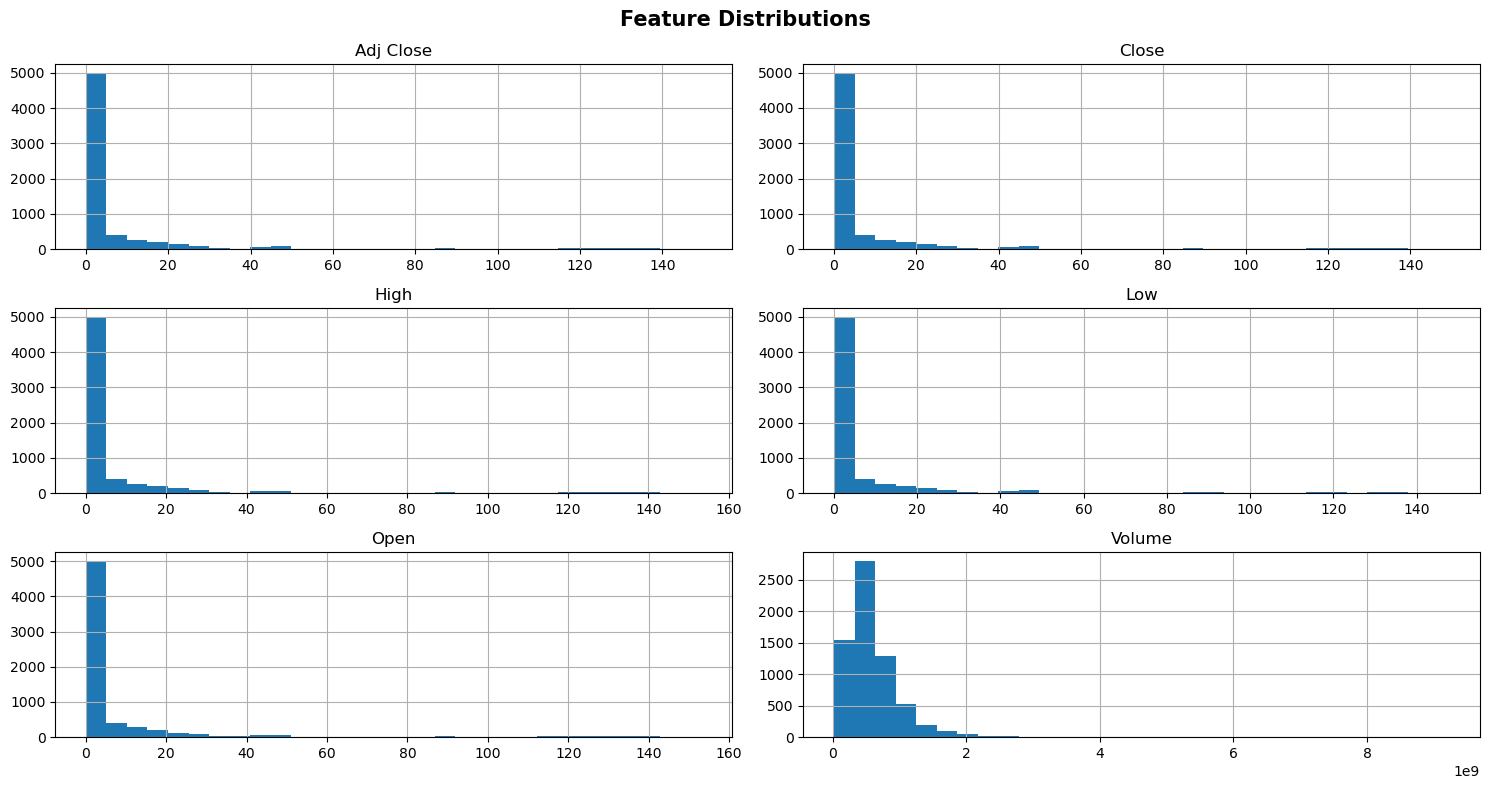

In [11]:
# Create histogram
NVIDIA_Stocks.hist(figsize=(15, 8), bins=30)

# Add main title
plt.suptitle("Feature Distributions", fontsize=15, fontweight='bold')

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Correlation Heatmap

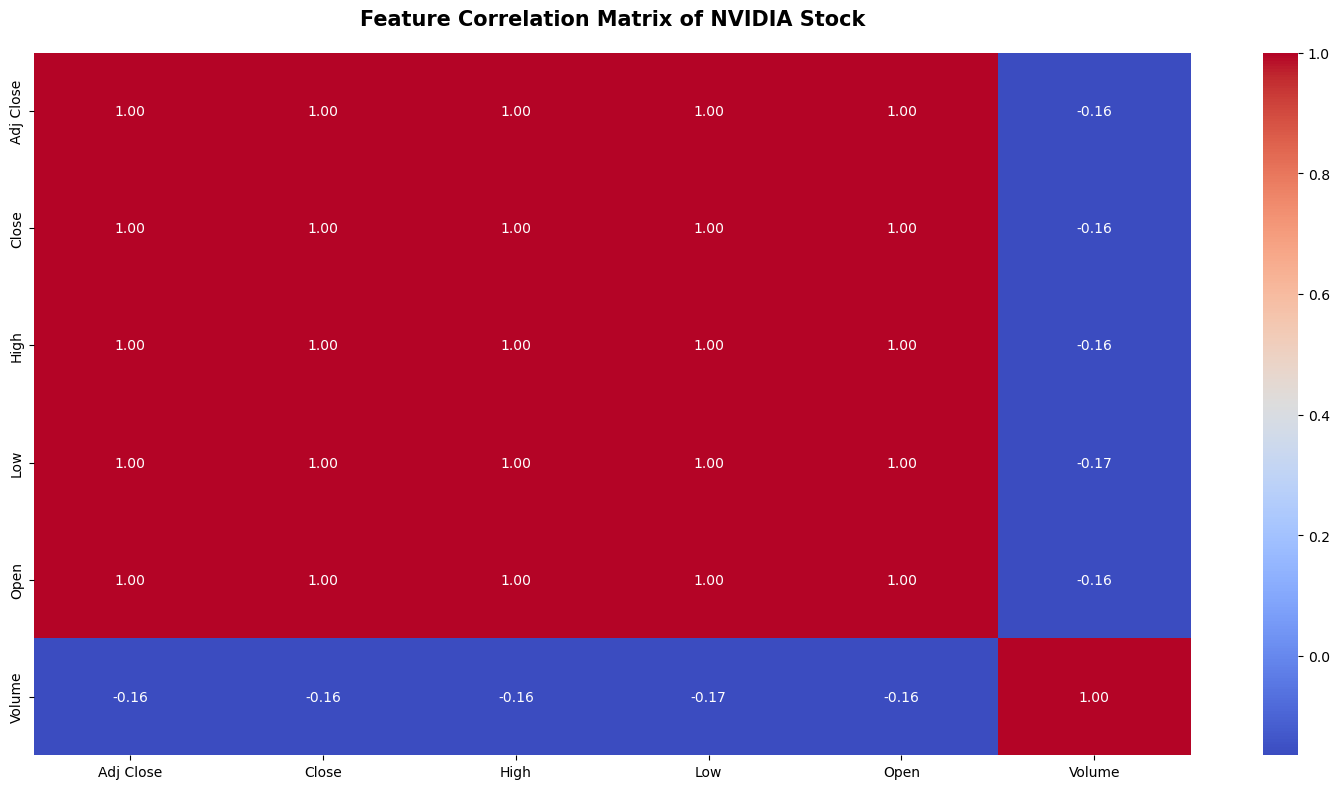

In [12]:
# Create Correlation Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(NVIDIA_Stocks.corr(), annot=True, cmap='coolwarm', fmt='.2f')

# Add title
plt.title('Feature Correlation Matrix of NVIDIA Stock', fontsize=15, fontweight='bold', pad=20)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## NVIDIA Stock Price with Moving Averages

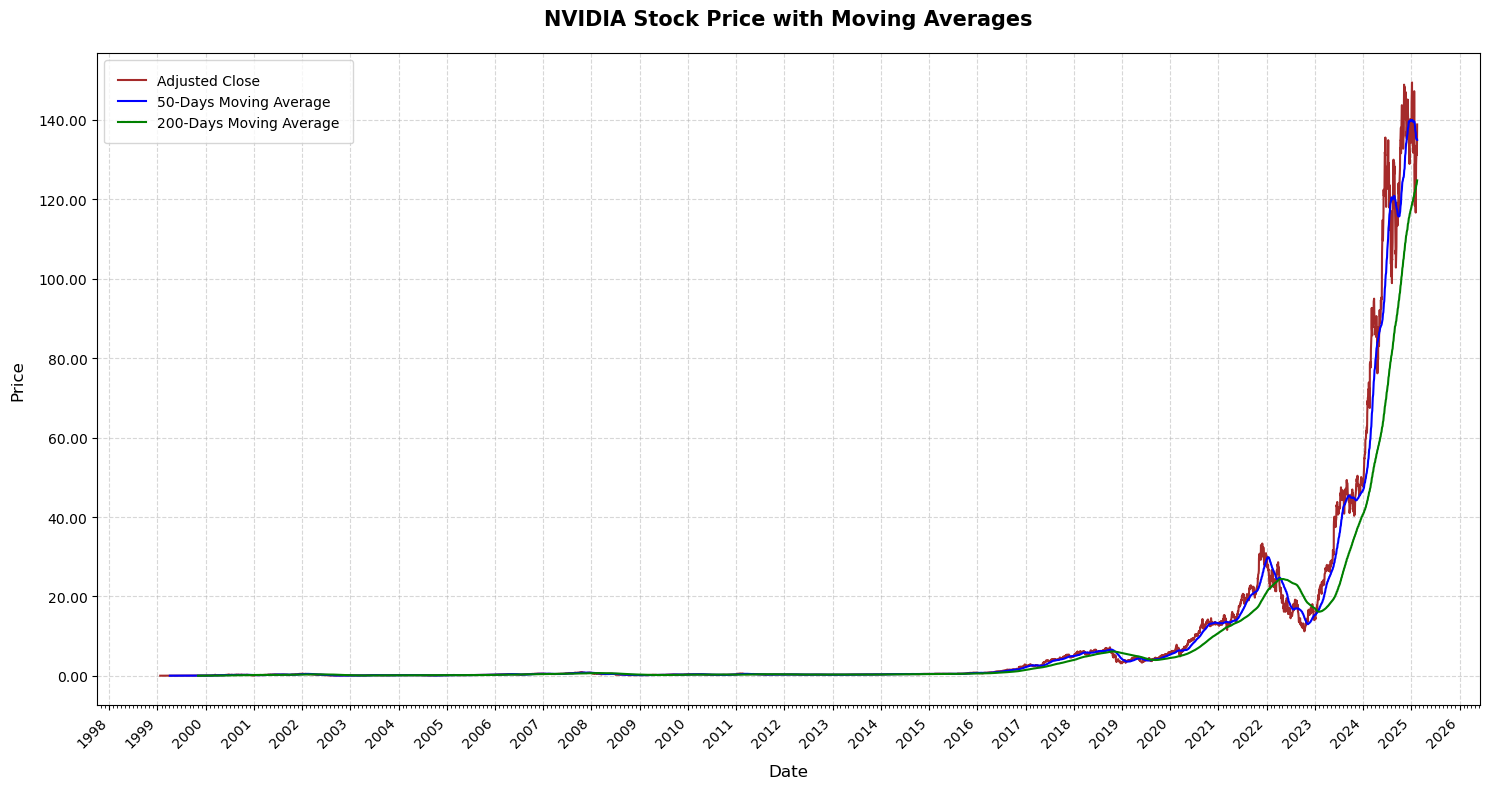

In [13]:
# Calculate Moving Averages
NVIDIA_Stocks['50_day_MA'] = NVIDIA_Stocks['Adj Close'].rolling(window=50).mean()
NVIDIA_Stocks['200_day_MA'] = NVIDIA_Stocks['Adj Close'].rolling(window=200).mean()

# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['Adj Close'], label='Adjusted Close', color='brown')
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['50_day_MA'], label='50-Days Moving Average', color='blue')
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['200_day_MA'], label='200-Days Moving Average', color='green')

# Add title and labels
plt.title('NVIDIA Stock Price with Moving Averages', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Price', fontsize=12, labelpad=10)

# Optimize xticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=10, rotation=45, ha='right')

# Optimize yticks
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## NVIDIA Stock Volatility Analysis

### Daily Returns

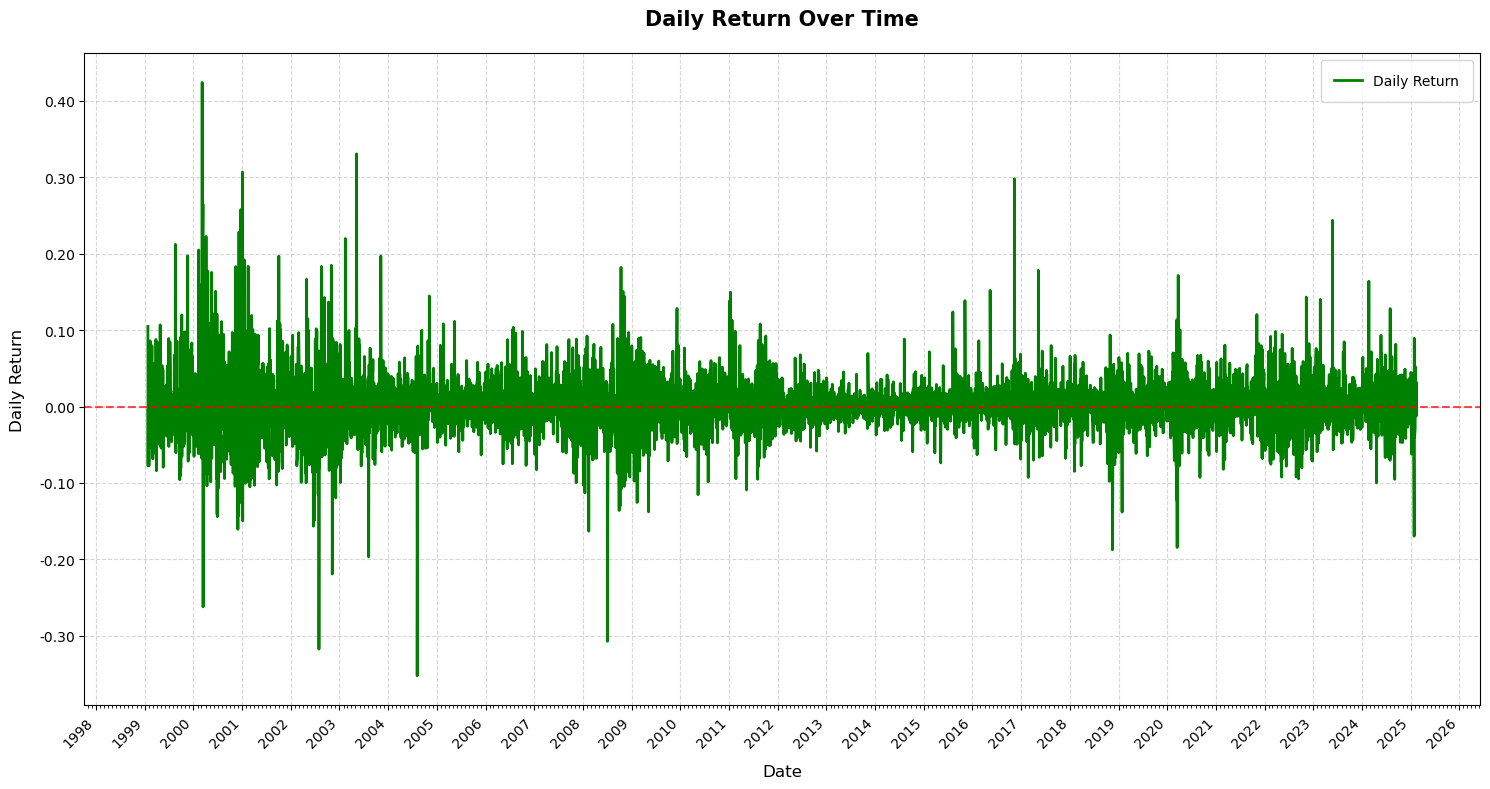

In [14]:
# Calculate Daily Return
NVIDIA_Stocks['Daily_Return'] = NVIDIA_Stocks['Adj Close'].pct_change()

# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['Daily_Return'], label='Daily Return', color='green', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)

# Add title and labels
plt.title('Daily Return Over Time', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Daily Return', fontsize=12, labelpad=10)

# Optimize xticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=10, rotation=45, ha='right')

# Optimize yticks
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper right', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Cumulative Return

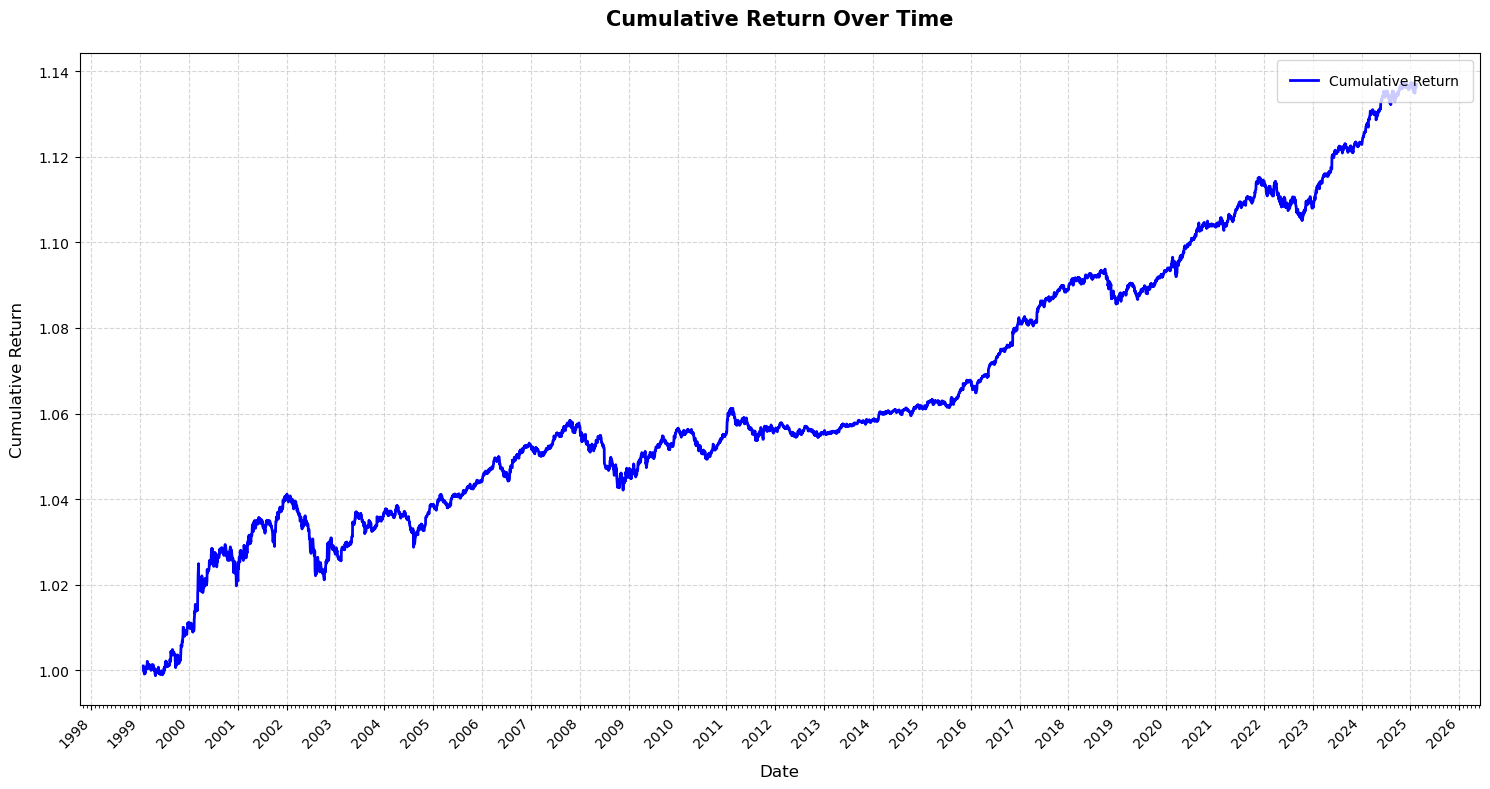

In [15]:
# Calculate Cumulative Return
NVIDIA_Stocks['Cumulative_Return'] = (1 + NVIDIA_Stocks['Daily_Return'] / 100).cumprod()

# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(NVIDIA_Stocks.index, NVIDIA_Stocks['Cumulative_Return'], label='Cumulative Return', color='blue', linewidth=2)

# Add title and labels
plt.title('Cumulative Return Over Time', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Cumulative Return', fontsize=12, labelpad=10)

# Optimize xticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=10, rotation=45, ha='right')

# Optimize yticks
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper right', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## NVIDIA Stock Price Decomposition



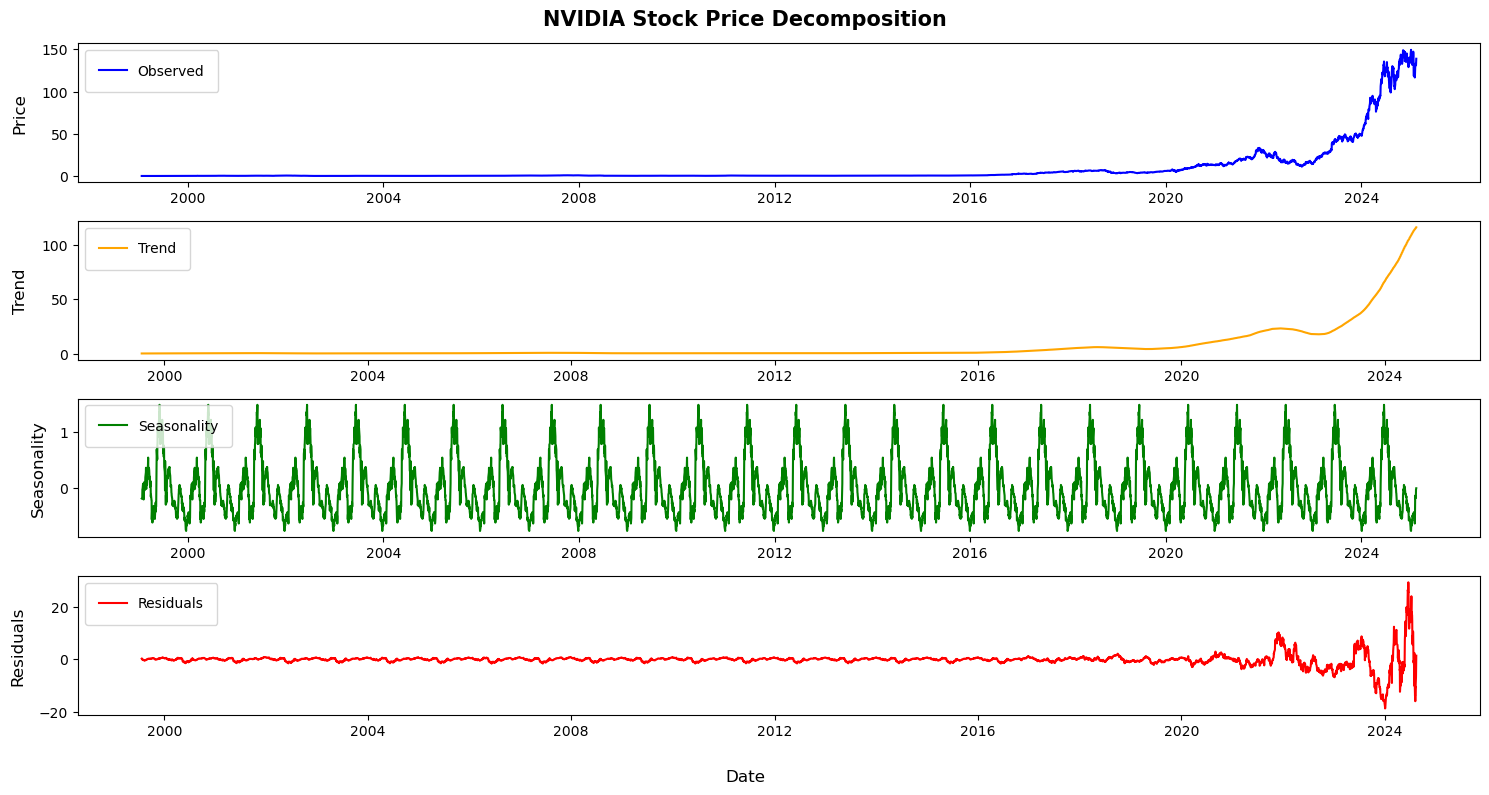

In [16]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(NVIDIA_Stocks['Adj Close'], model='additive', period=252)

# Plot the decomposition
plt.figure(figsize=(15, 8))

# Add main title
plt.suptitle('NVIDIA Stock Price Decomposition', fontsize=15, fontweight='bold')

# Observed (Original Data)
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)
plt.ylabel('Price', fontsize=12, labelpad=10)

# Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)
plt.ylabel('Trend', fontsize=12, labelpad=10)

# Seasonality
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)
plt.ylabel('Seasonality', fontsize=12, labelpad=10)

# Residuals
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)
plt.ylabel('Residuals', fontsize=12, labelpad=10)

# Add common x-label below all subplots
plt.figtext(0.5, 0.02, 'Date', ha='center', va='center', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Show the plot
plt.show()

# NVIDIA Stock Price Forecasting

## Traditional Methods (ARIMA and SARIMA)

### Data Preparation


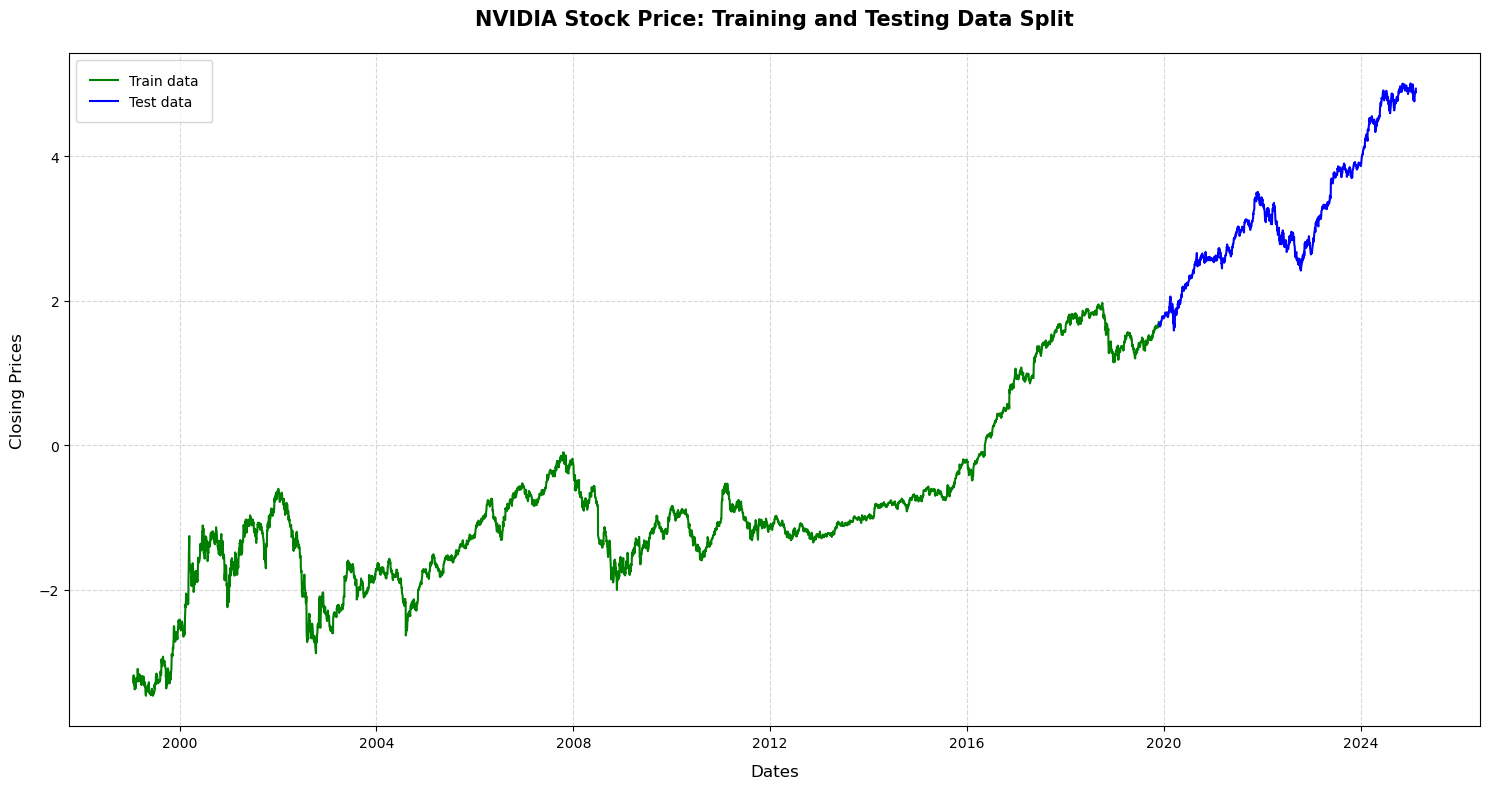

In [17]:
# Split data into train and test
df_log = np.log(NVIDIA_Stocks['Adj Close'])
train_data, test_data = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]


plt.figure(figsize=(15, 8))
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')

# Add title and labels
plt.title('NVIDIA Stock Price: Training and Testing Data Split', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Dates', fontsize=12, labelpad=10)
plt.ylabel('Closing Prices', fontsize=12, labelpad=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

### ARIMA Implementation

d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\depreca

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-19265.982, Time=3.62 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19262.785, Time=0.92 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19261.961, Time=0.97 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-19261.997, Time=1.73 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19261.598, Time=0.52 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-19258.118, Time=11.10 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19259.100, Time=5.11 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-19256.237, Time=5.15 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-19268.830, Time=12.69 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-19257.173, Time=7.01 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-19258.321, Time=15.16 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-19262.771, Time=14.51 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-19259.531, Time=14.07 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=18.88 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-19283.761, Time=6.81 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-19256.010, Time=4.26 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-19264.460, Time=4.51 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-19275.644, Time=8.91 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-19256.598, Time=3.04 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-19257.047, Time=1.88 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-19257.369, Time=2.46 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-19256.624, Time=4.46 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=10.02 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 157.888 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5246
Model:               SARIMAX(2, 1, 3)   Log Likelihood                9647.880
Date:                Tue, 25 Mar 2025   AIC                         -19283.761
Time:                        11:13:32   BIC                         -19244.371
Sample:                             0   HQIC                        -19269.989
                               - 5246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5567      0.012    -48.260      0.000      -0.579   

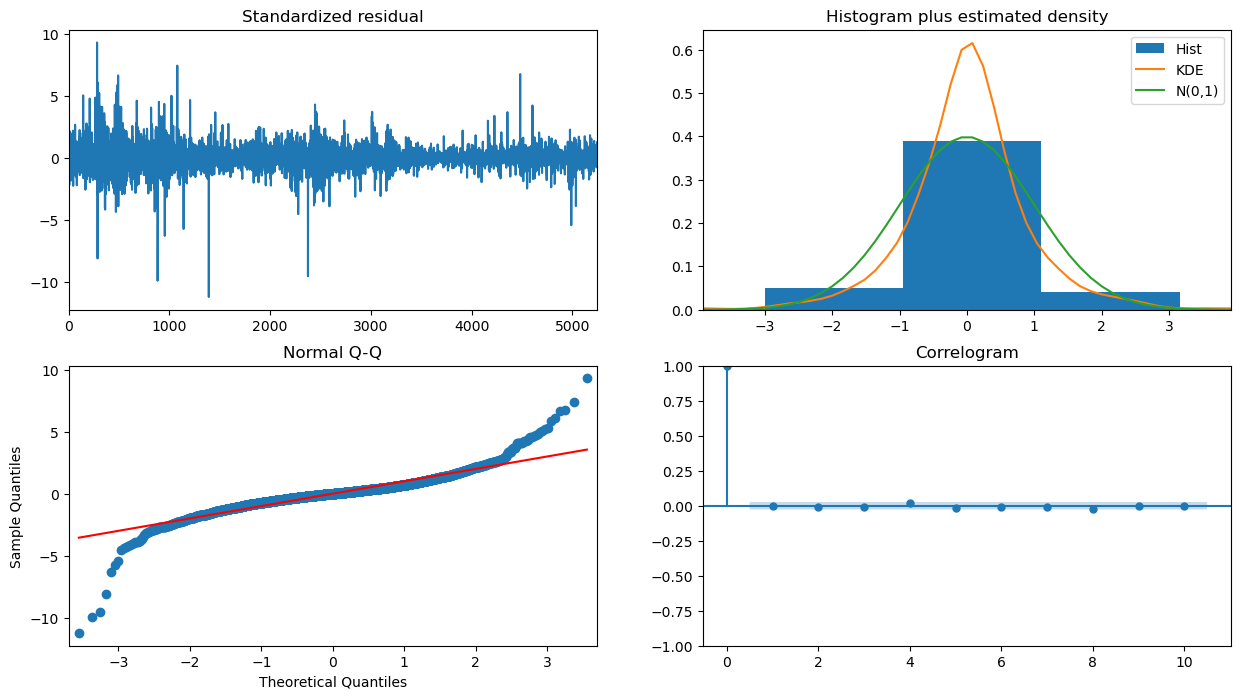

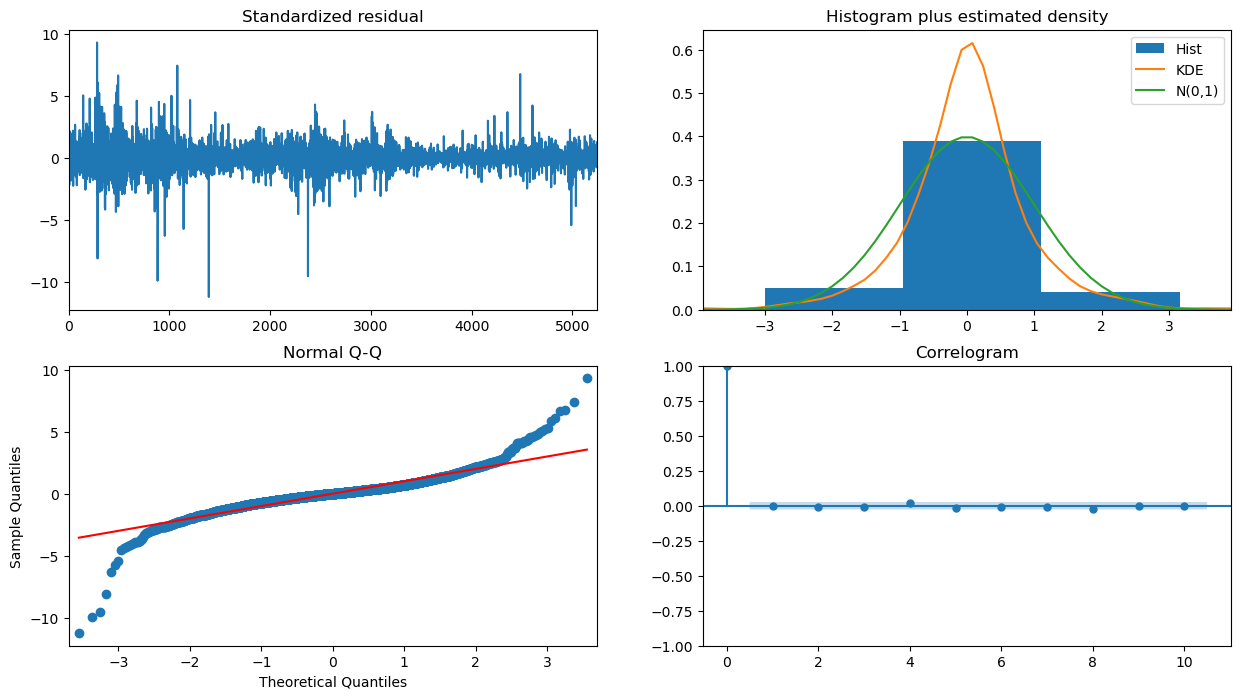

In [20]:
autoARIMA = pm.auto_arima(train_data,
                          seasonal=False,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          max_order=None,
                          trace=True)

print(autoARIMA.summary())
autoARIMA.plot_diagnostics(figsize=(15,8))

In [21]:
arima_model = ARIMA(train_data, order=(autoARIMA.order))
arima_fit = arima_model.fit()
print(arima_fit.summary())

d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5246
Model:                 ARIMA(2, 1, 3)   Log Likelihood                9647.880
Date:                Tue, 25 Mar 2025   AIC                         -19283.761
Time:                        11:13:41   BIC                         -19244.371
Sample:                             0   HQIC                        -19269.989
                               - 5246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5567      0.012    -48.260      0.000      -0.579      -0.534
ar.L2         -0.9657      0.012    -77.840      0.000      -0.990      -0.941
ma.L1          0.5747      0.015     38.446      0.0

d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


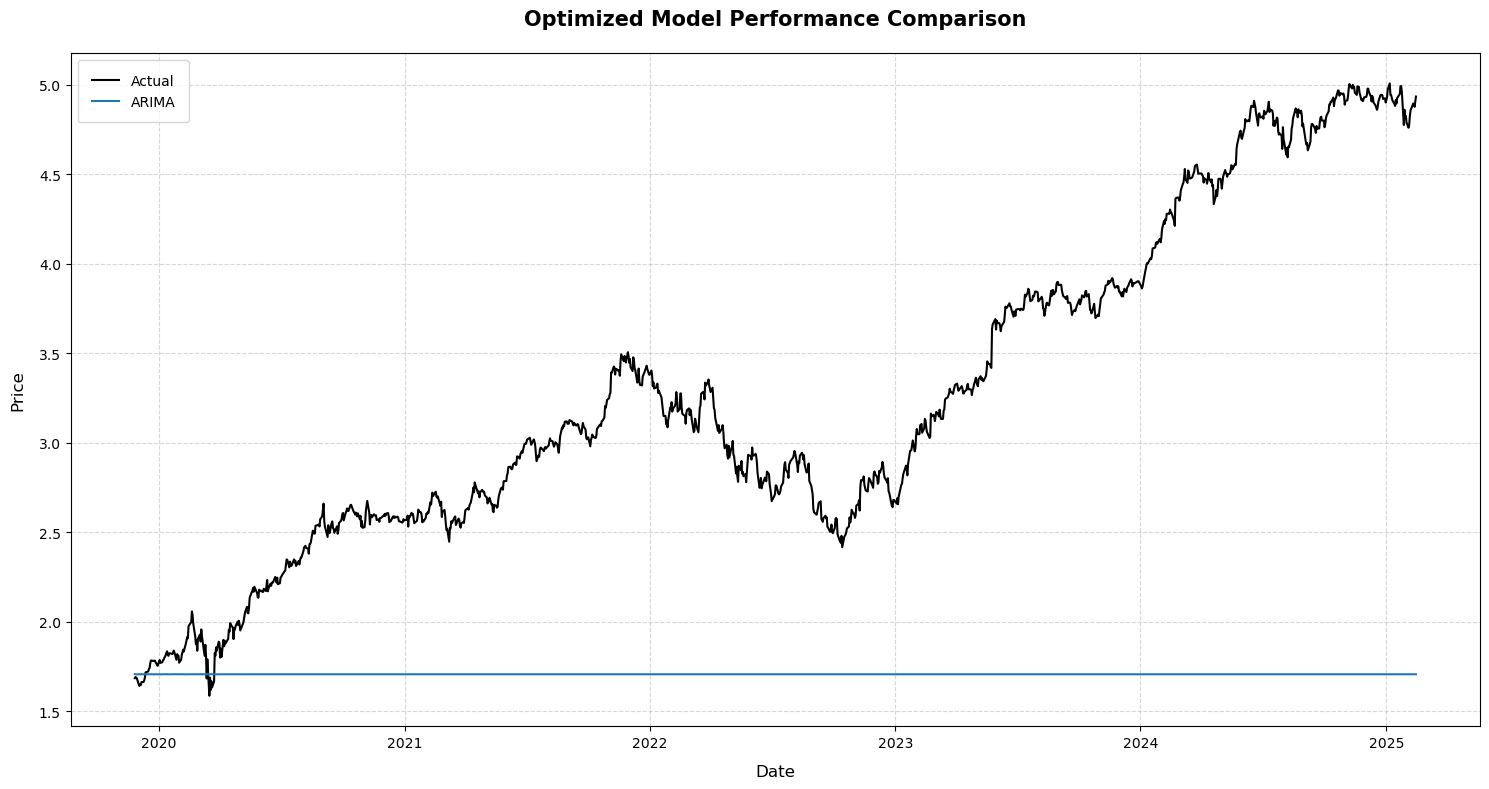

In [22]:
arima_forecast = arima_fit.forecast(steps=len(test_data))

plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='Actual', color='black')
plt.plot(test_data.index, arima_forecast, label='ARIMA')

# Add title and labels
plt.title('Optimized Model Performance Comparison', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Price', fontsize=12, labelpad=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

### SARIMA Implementation

d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\APP\Anaconda\Lib\site-packages\sklearn\utils\depreca

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=-19265.440, Time=7.35 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-19262.785, Time=0.74 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-19265.950, Time=3.07 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-19265.832, Time=7.08 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-19261.598, Time=0.51 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-19261.961, Time=1.02 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[5] intercept   : AIC=-19264.953, Time=3.28 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=-19266.440, Time=3.11 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=-19265.792, Time=1.35 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[5] intercept   : AIC=-19264.666, Time=5.11 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[5] intercept   : AIC=-19264.148, Time=4.85 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[5] intercept   : AIC=-19264.768, Time=8.44 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[5] intercept   : AIC=-19266.158, Time=17.31 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=-19267.040, Time=3.38 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=-19266.517, Time=3.38 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=-19266.672, Time=3.35 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=-19265.234, Time=6.82 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=-19264.746, Time=7.99 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=-19265.405, Time=5.98 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=-19265.597, Time=2.76 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=-19266.721, Time=15.85 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=-19266.479, Time=4.21 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=-19268.771, Time=14.30 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=-19262.920, Time=6.91 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=-19263.117, Time=6.48 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[5] intercept   : AIC=-19266.939, Time=20.06 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[5] intercept   : AIC=-19262.076, Time=20.39 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-19258.789, Time=2.96 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[5] intercept   : AIC=-19262.104, Time=14.75 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[5] intercept   : AIC=-19262.360, Time=11.18 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[5] intercept   : AIC=-19264.832, Time=28.16 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[5] intercept   : AIC=-19263.412, Time=9.25 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=-19263.456, Time=12.55 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[5] intercept   : AIC=-19265.433, Time=4.59 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[5] intercept   : AIC=-19265.396, Time=6.86 sec


d:\APP\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[5]             : AIC=-19267.412, Time=5.15 sec

Best model:  ARIMA(1,1,1)(1,0,1)[5] intercept
Total fit time: 280.725 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 5246
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood                9640.386
Date:                           Tue, 25 Mar 2025   AIC                         -19268.771
Time:                                   11:18:23   BIC                         -19229.381
Sample:                                        0   HQIC                        -19254.999
                                          - 5246                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

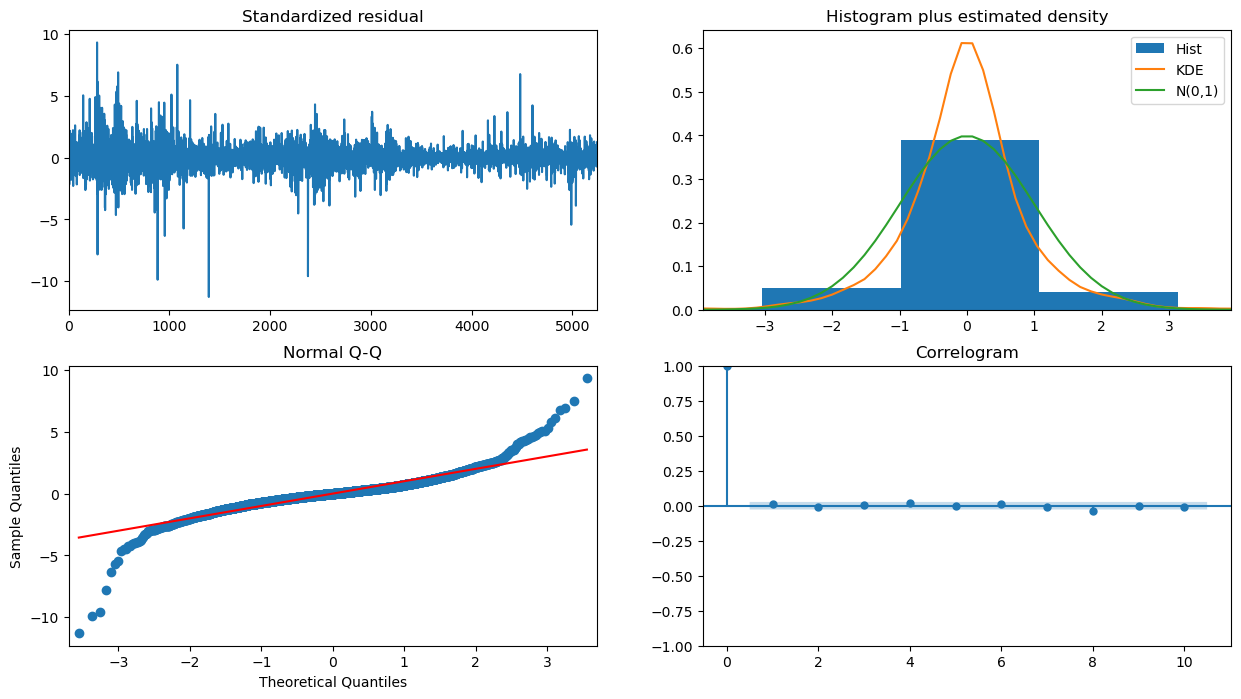

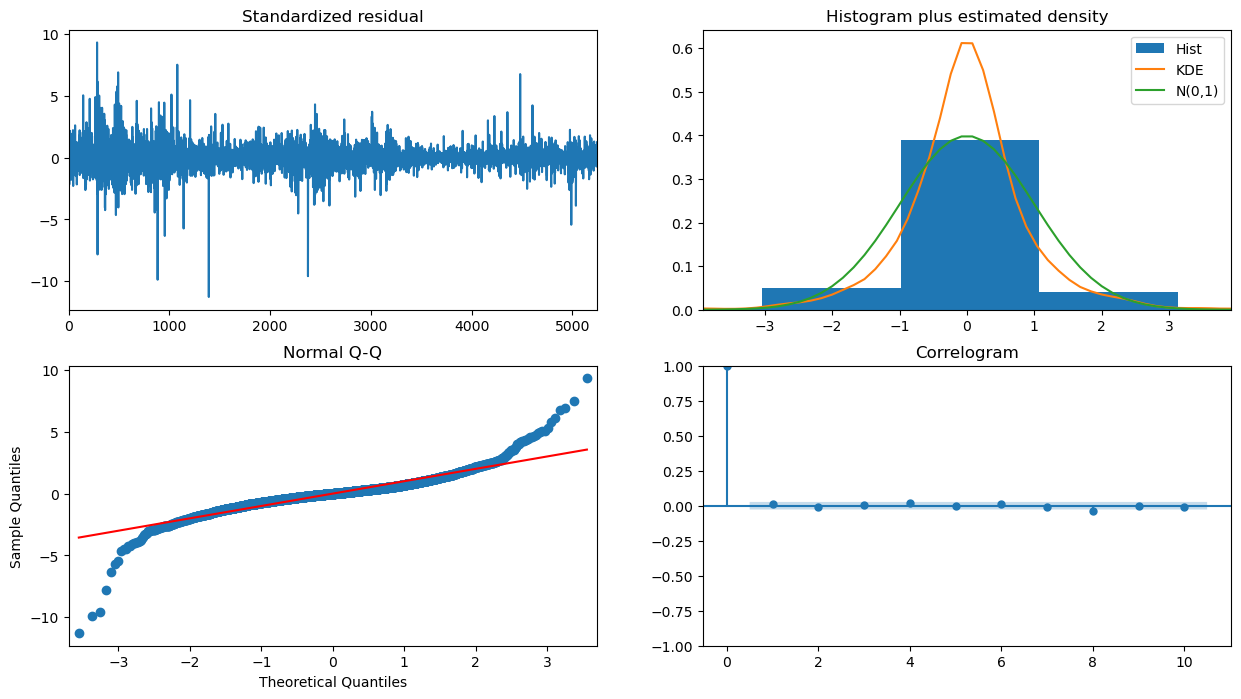

In [23]:
autoSAMIRA = pm.auto_arima(train_data,
                           seasonal=True,
                           m=5,  # Weekly seasonality (5 trading days)
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore',
                           max_order=None,
                           trace=True)

print(autoSAMIRA.summary())
autoSAMIRA.plot_diagnostics(figsize=(15,8))

In [24]:
sarima_model = SARIMAX(train_data, order=(autoSAMIRA.order), seasonal_order=(autoSAMIRA.seasonal_order))
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                         Adj Close   No. Observations:                 5246
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood                9638.706
Date:                           Tue, 25 Mar 2025   AIC                         -19267.412
Time:                                   11:18:31   BIC                         -19234.587
Sample:                                        0   HQIC                        -19255.935
                                          - 5246                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9533      0.041    -23.288      0.000      -1.034      -0.873
ma.L1          0.9598      0.039     24.728

d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


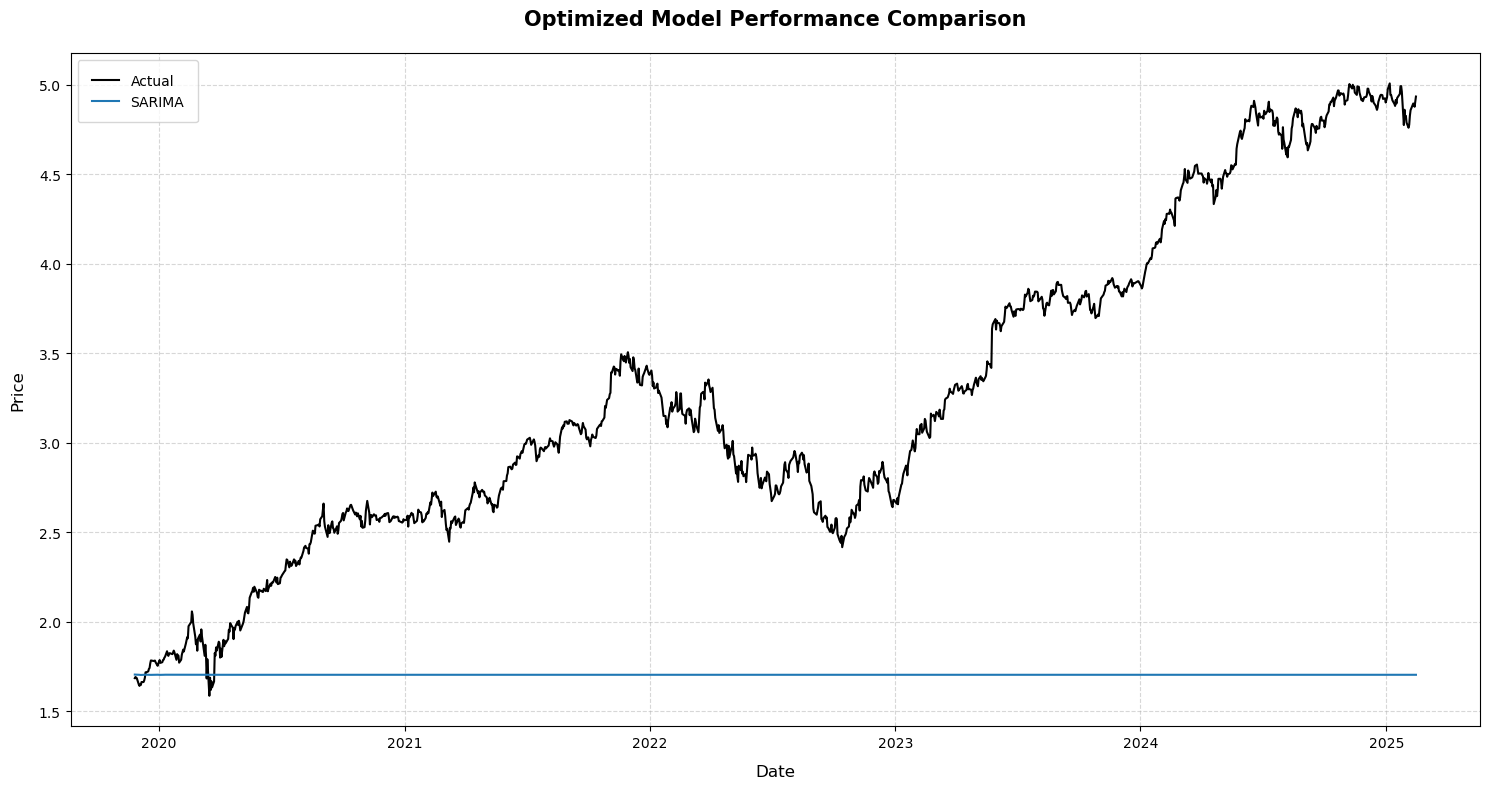

In [25]:
sarima_forecast = sarima_fit.get_forecast(steps=len(test_data)).predicted_mean

plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='Actual', color='black')
plt.plot(test_data.index, sarima_forecast, label='SARIMA')

# Add title and labels
plt.title('Optimized Model Performance Comparison', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Price', fontsize=12, labelpad=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
plt.legend(loc='upper left', fontsize=10, frameon=True, borderpad=1)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Deep Learning Models

### Data Preparation

In [26]:
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(len(data)-time_step-1):
        x.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(x), np.array(y)


data = NVIDIA_Stocks[['Adj Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

x, y = create_dataset(scaled_data)

train_size = int(len(x) * 0.8)
x_train, x_test = x[:int(len(x) * 0.8)], x[int(len(x) * 0.8):]
y_train, y_test = y[:int(len(x) * 0.8)], y[int(len(x) * 0.8):]

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

### LSTM Implementation

In [27]:
# Xây dựng mô hình LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Huấn luyện mô hình
lstm_history = lstm_model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Dự báo
train_predict = lstm_model.predict(x_train)
test_predict = lstm_model.predict(x_test)

# Chuyển đổi về giá trị ban đầu
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
lstm_mae = mean_absolute_error(y_test_actual, test_predict)

d:\APP\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - loss: 5.4613e-05 - val_loss: 0.0041
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 3.4616e-06 - val_loss: 0.0028
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 3.7829e-06 - val_loss: 0.0025
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 2.5278e-06 - val_loss: 0.0029
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 2.4196e-06 - val_loss: 0.0019
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 4.6046e-06 - val_loss: 0.0027
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 2.1890e-06 - val_loss: 0.0020
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 2.1397e-06 - val_loss: 0.0021
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 2.0796e-06 - val_loss: 0.0016
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 2.2294e-06 - val_loss: 0.0026
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 2.2266e-06 - val_loss: 0.0015
Epoch 12/50
82/82